In [1]:
from easy_transformer import EasyTransformer

from transformers import GPT2Model, GPT2Tokenizer

import torch
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

import TransformerGPT_with_MLP as tgm
import data_gen as dg
import images
import fine_tune as ft

from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

c:\Users\gdhim\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
gpt2small = EasyTransformer.from_pretrained("gpt2-small", fold_ln=False, center_unembed=False, center_writing_weights=False)
tokenizer = gpt2small.tokenizer

Moving model to device:  cuda
Finished loading pretrained model gpt2-small into EasyTransformer!


In [3]:
cfg = tgm.Config()
cfg.d_residual = 768
cfg.debug = False
cfg.layer_norm_eps = 1e-5
cfg.d_vocab = 50257
cfg.init_range = 0.02
cfg.max_length = 1024
cfg.d_head = 64
cfg.n_heads = 12
cfg.n_layers = 12

model = tgm.Transformer(cfg).to(device)

previoous token head :\
*2:2     2:9*     **4:11**

dupplicate token head :\
**0:1**     0:10    3:0

induction head :\
**5:5**     *5:8     5:9*     **6:9**

S-inhibition head :\
7:3     7:9     **8:6     8:10**

In [4]:
model.load_state_dict(gpt2small.state_dict(), strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['blocks.0.attn.mask', 'blocks.1.attn.mask', 'blocks.2.attn.mask', 'blocks.3.attn.mask', 'blocks.4.attn.mask', 'blocks.5.attn.mask', 'blocks.6.attn.mask', 'blocks.7.attn.mask', 'blocks.8.attn.mask', 'blocks.9.attn.mask', 'blocks.10.attn.mask', 'blocks.11.attn.mask'])

In [5]:
def create_repeating_random_sentence(size = 10, num_repeats = 3):
    random_sequence = torch.randint(0, 52000, (size,))
    repeated = torch.cat([random_sequence for _ in range(num_repeats)])
    return repeated.unsqueeze(0)

In [6]:
sentence = "Mr and Mrs Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much. They were the last people you'd expect to be involved in anything strange or mysterious, because they just didn't hold with such nonsense. Mr Dursley was the director of a firm called Grunnings, which made drills. He was a big, beefy man with hardly any neck, although he did have a very large moustache. Mrs Dursley was thin and blonde and had nearly twice the usual amount of neck, which came in very useful as she spent so much of her time craning over garden fences, spying on the neighbours. The Dursleys had a small son called Dudley and in their opinion there was no finer boy anywhere. The Dursleys had everything they wanted, but they also had a secret, and their greatest fear was that somebody would discover it. They didn't think they could bear it if anyone found out about the Potters. Mrs Potter was Mrs Dursley's sister, but they hadn't met for several years; in fact, Mrs Dursley pretended she didn't have a sister, because her sister and her good- for-nothing husband were as unDursleyish as it was possible to be. The Dursleys shuddered to think what the neighbours would say if the Potters arrived in the street. The Dursleys knew that the Potters had a small son, too, but they had never even seen him. This boy was another good reason for keeping the Potters away; they didn't want Dudley mixing with a child like that."
tokens = tokenizer.encode(sentence)

tokens = torch.tensor([tokens]).to("cuda:0")

tokens = create_repeating_random_sentence(size=20, num_repeats=10)
print(tokens.shape)

torch.Size([1, 200])


In [7]:
gptpred = gpt2small(tokens)

pred = model(tokens)

In [8]:
#tokens = gptpred[0].argmax(dim=-1).tolist()

#gptpred = gpt2small.tokenizer.batch_decode(gptpred.argmax(dim=-1)[0])

In [9]:
print("GPT-2 Prediction:\n")
#print(tokenizer.decode(gptpred[0].argmax(dim=-1).tolist()))

print("\nCOPY Prediction:\n")
#print(tokenizer.decode(pred[0].argmax(dim=-1).tolist()))

GPT-2 Prediction:


COPY Prediction:



In [10]:
def plot_attention(model, x, fine_tuned = False):
    model(x)

    previous_token_head = []
    dupplicate_head = []
    induction_head = []
    s_inhibition_head = []

    h22 = model.blocks[2].attn.attention[0][2].cpu().detach().numpy()
    h22 = np.uint8(h22 * 255 / np.max(h22, axis = 1))
    h22 = Image.fromarray(h22)
    previous_token_head.append(h22)

    h29 = model.blocks[2].attn.attention[0][9].cpu().detach().numpy()
    h29 = np.uint8(h29 * 255 / np.max(h29, axis = 1))
    h29 = Image.fromarray(h29)
    previous_token_head.append(h29)

    h411 = model.blocks[4].attn.attention[0][11].cpu().detach().numpy()
    h411 = np.uint8(h411 * 255 / np.max(h411, axis = 1))
    h411 = Image.fromarray(h411)
    previous_token_head.append(h411)

    h01 = model.blocks[0].attn.attention[0][1].cpu().detach().numpy()
    h01 = np.uint8(h01 * 255 / np.max(h01, axis = 1))
    h01 = Image.fromarray(h01)
    dupplicate_head.append(h01)

    h010 = model.blocks[0].attn.attention[0][10].cpu().detach().numpy()
    h010 = np.uint8(h010 * 255 / np.max(h010, axis = 1))
    h010 = Image.fromarray(h010)
    dupplicate_head.append(h010)

    h30 = model.blocks[3].attn.attention[0][0].cpu().detach().numpy()
    h30 = np.uint8(h30 * 255 / np.max(h30, axis = 1))
    h30 = Image.fromarray(h30)
    dupplicate_head.append(h30)

    h55 = model.blocks[5].attn.attention[0][5].cpu().detach().numpy()
    h55 = np.uint8(h55 * 255 / np.max(h55, axis = 1))
    h55 = Image.fromarray(h55)
    induction_head.append(h55)

    h58 = model.blocks[5].attn.attention[0][8].cpu().detach().numpy()
    h58 = np.uint8(h58 * 255 / np.max(h58, axis = 1))
    h58 = Image.fromarray(h58)
    induction_head.append(h58)

    h59 = model.blocks[5].attn.attention[0][9].cpu().detach().numpy()
    h59 = np.uint8(h59 * 255 / np.max(h59, axis = 1))
    h59 = Image.fromarray(h59)
    induction_head.append(h59)

    h69 = model.blocks[6].attn.attention[0][9].cpu().detach().numpy()
    h69 = np.uint8(h69 * 255 / np.max(h69, axis = 1))
    h69 = Image.fromarray(h69)
    induction_head.append(h69)

    h73 = model.blocks[7].attn.attention[0][3].cpu().detach().numpy()
    h73 = np.uint8(h73 * 255 / np.max(h73, axis = 1))
    h73 = Image.fromarray(h73)
    s_inhibition_head.append(h73)

    h79 = model.blocks[7].attn.attention[0][9].cpu().detach().numpy()
    h79 = np.uint8(h79 * 255 / np.max(h79, axis = 1))
    h79 = Image.fromarray(h79)
    s_inhibition_head.append(h79)

    h86 = model.blocks[8].attn.attention[0][6].cpu().detach().numpy()
    h86 = np.uint8(h86 * 255 / np.max(h86, axis = 1))
    h86 = Image.fromarray(h86)
    s_inhibition_head.append(h86)

    h810 = model.blocks[8].attn.attention[0][10].cpu().detach().numpy()
    h810 = np.uint8(h810 * 255 / np.max(h810, axis = 1))
    h810 = Image.fromarray(h810)
    s_inhibition_head.append(h810)

    images.imshow(previous_token_head, title="Previous token head")
    images.imshow(dupplicate_head, title="Dupplicate head")
    images.imshow(induction_head, title="Induction head")
    images.imshow(s_inhibition_head, title="S-inhibition head")


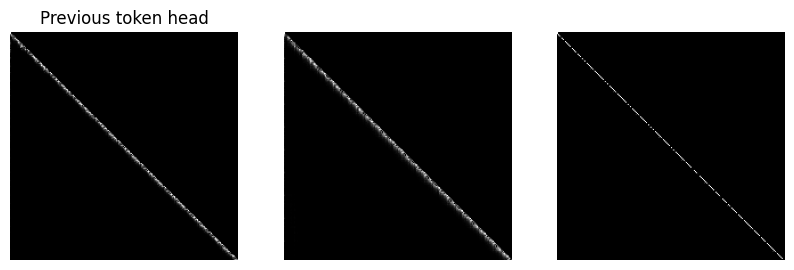

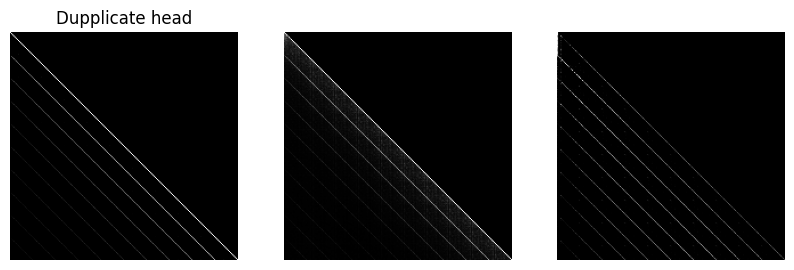

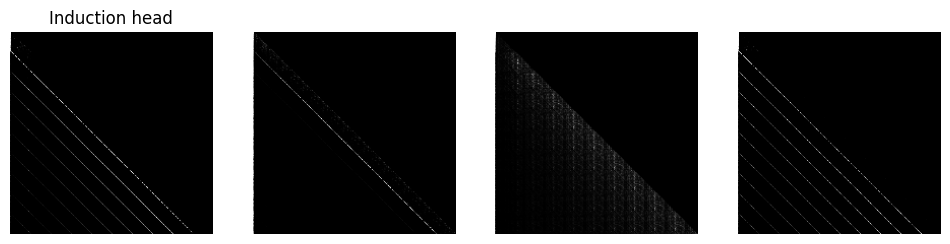

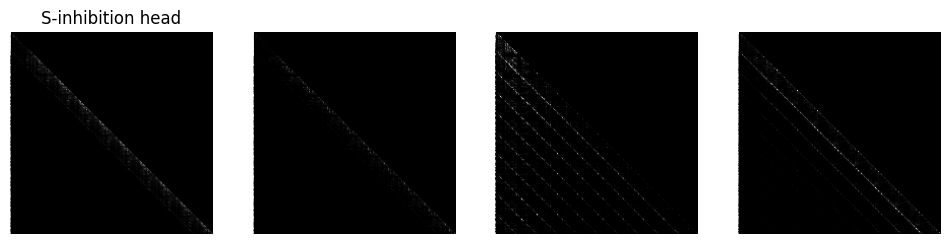

In [11]:
plot_attention(model, tokens)

generating data...


100%|██████████| 1040/1040 [00:16<00:00, 63.59it/s]


done


100%|██████████| 15/15 [05:03<00:00, 20.20s/it]


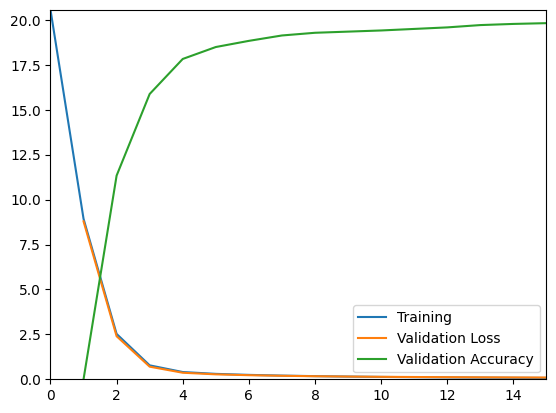

In [14]:
ft.fine_tune(model, lr = 1e-6, N=1024, N_Val=16, size=60, epochs=15, batch_size=8, verbose = False)

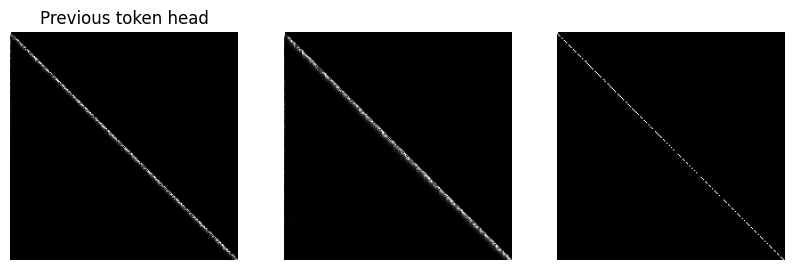

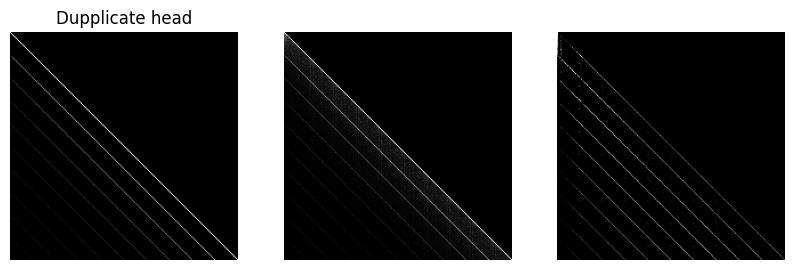

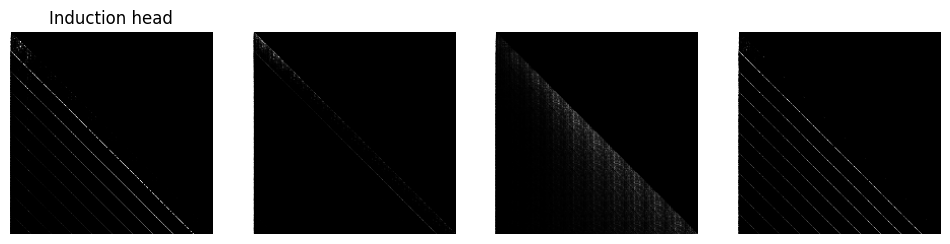

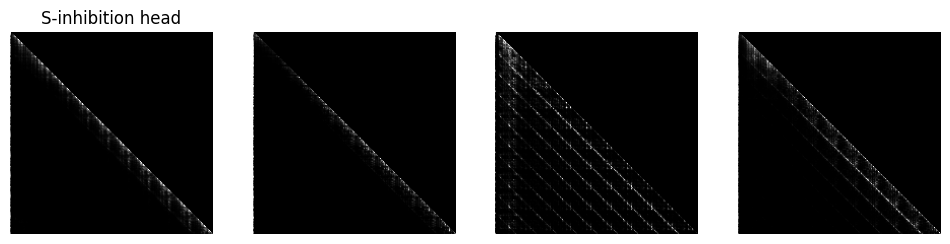

In [13]:
plot_attention(model, tokens)